# How to build a linear factor model

Algorithmic trading strategies use linear factor models to quantify the relationship between the return of an asset and the sources of risk that represent the main drivers of these returns. Each factor risk carries a premium, and the total asset return can be expected to correspond to a weighted average of these risk premia.

There are several practical applications of factor models across the portfolio management process from construction and asset selection to risk management and performance evaluation. The importance of factor models continues to grow as common risk factors are now tradeable:

- A summary of the returns of many assets by a much smaller number of factors reduces the amount of data required to estimate the covariance matrix when optimizing a portfolio
- An estimate of the exposure of an asset or a portfolio to these factors allows for the management of the resultant risk, for instance by entering suitable hedges when risk factors are themselves traded
- A factor model also permits the assessment of the incremental signal content of new alpha factors
- A factor model can also help assess whether a manager's performance relative to a benchmark is indeed due to skill in selecting assets and timing the market, or if instead, the performance can be explained by portfolio tilts towards known return drivers that can today be replicated as low-cost, passively managed funds without incurring active management fees

## Imports & Settings

In [1]:
from pprint import pprint
from pandas_datareader.famafrench import get_available_datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.api import OLS, add_constant
from pathlib import Path
import warnings
from linearmodels.asset_pricing import TradedFactorModel, LinearFactorModel, LinearFactorModelGMM

In [2]:
# due to https://stackoverflow.com/questions/50394873/import-pandas-datareader-gives-importerror-cannot-import-name-is-list-like
# may become obsolete when fixed
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web

In [3]:
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

## Get Data

Fama and French make updated risk factor and research portfolio data available through their [website](http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html), and you can use the `pandas_datareader` package to obtain the data.

### Risk Factors

In particular, we will be using the five Fama—French factors that result from sorting stocks first into three size groups and then into two for each of the remaining three firm-specific factors. 

Hence, the factors involve three sets of value-weighted portfolios formed as 3 x 2 sorts on size and book-to-market, size and operating profitability, and size and investment. The risk factor values computed as the average returns of the portfolios (PF) as outlined in the following table:

| Label | Name                          | Description                                                                                                                                                                               |
|-------|-------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| SMB   | Small Minus Big               | Average return on the nine small stock portfolios minus the average return on the nine big stock portfolios                                                                               |
| HML   | High Minus Low                | Average return on the two value portfolios minus the average return on the two growth portfolios                                                                                          |
| RMW   | Robust minus Weak             | Average return on the two robust operating profitability portfolios minus the average return on the two weak operating profitability portfolios                                           |
| CMA   | Conservative Minus Aggressive | Average return on the two conservative investment portfolios minus the average return on the two aggressive investment portfolios                                                         |
| Rm-Rf | Excess return on the market   | Value-weight return of all firms incorporated in the US and listed on the NYSE, AMEX, or NASDAQ at the beginning of month t with 'good' data for t minus the one-month Treasury bill rate |

The Fama-French 5 factors are based on the 6 value-weight portfolios formed on size and book-to-market, the 6 value-weight portfolios formed on size and operating profitability, and the 6 value-weight portfolios formed on size and investment.

We will use returns at a monthly frequency that we obtain for the period 2010 – 2017 as follows:

In [24]:
ff_factor = 'F-F_Research_Data_5_Factors_2x3'
ff_factor_data = web.DataReader(ff_factor, 'famafrench', start='2007', end='2023-03')[0]
ff_factor_data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 195 entries, 2007-01 to 2023-03
Freq: M
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  195 non-null    float64
 1   SMB     195 non-null    float64
 2   HML     195 non-null    float64
 3   RMW     195 non-null    float64
 4   CMA     195 non-null    float64
 5   RF      195 non-null    float64
dtypes: float64(6)
memory usage: 10.7 KB


In [25]:
ff_factor_data.describe()

,Mkt-RF,SMB,HML,RMW,CMA,RF
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,0.756410,0.025590,-0.197641,0.364410,0.092154,0.073487
std,4.746669,2.620663,3.377682,1.911639,1.973275,0.112411
min,-17.230000,-8.300000,-13.950000,-4.780000,-6.920000,0.000000
25%,-1.960000,-1.860000,-1.925000,-0.765000,-1.175000,0.000000
50%,1.290000,0.140000,-0.450000,0.380000,-0.050000,0.010000
75%,3.420000,1.605000,1.285000,1.310000,1.250000,0.130000
max,13.650000,7.130000,12.750000,7.220000,7.740000,0.440000


In [26]:
ff_factor_data

,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
2007-01,1.40,0.08,-0.69,0.25,0.38,0.44
2007-02,-1.96,1.28,-0.13,-0.51,-0.71,0.38
2007-03,0.68,0.19,-0.96,0.64,-0.65,0.43
2007-04,3.49,-2.03,-1.46,1.15,1.04,0.44
2007-05,3.24,0.40,-0.65,1.58,-1.36,0.41
...,...,...,...,...,...,...
2022-11,4.60,-2.67,1.38,6.01,3.11,0.29
2022-12,-6.41,-0.16,1.32,0.09,4.19,0.33
2023-01,6.65,4.43,-4.05,-2.62,-4.53,0.35


### Portfolios

Fama and French also make available numerous portfolios that we can illustrate the estimation of the factor exposures, as well as the value of the risk premia available in the market for a given time period. We will use a panel of the 17 industry portfolios at a monthly frequency. 

We will subtract the risk-free rate from the returns because the factor model works with excess returns:

In [27]:
ff_portfolio = '17_Industry_Portfolios'
ff_portfolio_data = web.DataReader(ff_portfolio, 'famafrench', start='2007', end='2023-03')[0]
ff_portfolio_data = ff_portfolio_data.sub(ff_factor_data.RF, axis=0)
ff_portfolio_data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 195 entries, 2007-01 to 2023-03
Freq: M
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Food    195 non-null    float64
 1   Mines   195 non-null    float64
 2   Oil     195 non-null    float64
 3   Clths   195 non-null    float64
 4   Durbl   195 non-null    float64
 5   Chems   195 non-null    float64
 6   Cnsum   195 non-null    float64
 7   Cnstr   195 non-null    float64
 8   Steel   195 non-null    float64
 9   FabPr   195 non-null    float64
 10  Machn   195 non-null    float64
 11  Cars    195 non-null    float64
 12  Trans   195 non-null    float64
 13  Utils   195 non-null    float64
 14  Rtail   195 non-null    float64
 15  Finan   195 non-null    float64
 16  Other   195 non-null    float64
dtypes: float64(17)
memory usage: 27.4 KB


In [28]:
ff_portfolio_data.describe()

,Food,Mines,Oil,Clths,Durbl,Chems,Cnsum,Cnstr,Steel,FabPr,Machn,Cars,Trans,Utils,Rtail,Finan,Other
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,0.769692,0.658769,0.677128,0.952974,0.576256,0.820410,0.836154,1.036205,0.672462,0.973333,1.061846,1.298051,0.861179,0.613333,0.882000,0.507590,0.887282
std,3.640223,8.619137,7.903438,6.791489,6.975556,6.804069,3.704425,6.473895,9.806203,5.872029,6.108104,9.038945,5.795609,4.111311,4.831551,6.295907,4.920163
min,-13.050000,-32.840000,-34.820000,-22.250000,-25.900000,-22.010000,-9.480000,-20.410000,-32.990000,-23.110000,-21.040000,-27.890000,-22.780000,-13.140000,-14.670000,-20.910000,-17.910000
25%,-1.285000,-5.280000,-3.165000,-3.095000,-3.210000,-2.370000,-1.645000,-2.935000,-5.215000,-1.950000,-2.230000,-3.705000,-2.240000,-1.595000,-1.460000,-2.770000,-1.935000
50%,0.870000,0.330000,0.980000,0.940000,0.940000,1.440000,1.080000,1.800000,1.560000,1.490000,1.990000,0.600000,1.080000,1.040000,0.850000,1.420000,1.680000
75%,3.205000,7.345000,4.650000,4.760000,4.410000,4.740000,3.445000,5.160000,6.550000,4.350000,4.705000,5.065000,4.485000,3.350000,3.680000,4.195000,3.935000
max,10.140000,21.940000,32.870000,23.330000,29.400000,20.100000,10.390000,17.990000,26.240000,18.810000,15.780000,38.710000,19.670000,10.350000,18.270000,17.110000,13.530000


In [29]:
ff_portfolio_data

,Food,Mines,Oil,Clths,Durbl,Chems,Cnsum,Cnstr,Steel,FabPr,Machn,Cars,Trans,Utils,Rtail,Finan,Other
Date,,,,,,,,,,,,,,,,,
2007-01,0.52,5.14,-1.75,2.71,1.33,2.99,2.68,3.03,9.27,2.26,1.19,3.91,3.42,-0.04,2.97,-0.01,2.02
2007-02,-2.49,5.23,-2.63,1.65,0.80,1.97,-3.18,-2.19,2.34,-1.36,-1.00,-0.16,-1.36,3.81,-0.54,-2.90,-2.94
2007-03,2.28,2.21,5.60,-0.02,-0.35,1.52,0.32,-5.15,5.68,1.73,0.20,-0.49,-0.38,3.87,0.86,-0.79,0.55
2007-04,3.81,7.63,4.51,1.70,6.62,1.41,4.90,1.93,2.94,4.38,5.57,5.11,3.53,3.50,2.14,3.23,3.13
2007-05,1.81,7.29,6.46,4.78,1.29,4.48,1.00,5.83,10.18,5.66,4.32,2.01,4.67,0.78,1.49,2.50,3.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11,3.89,16.90,0.47,16.61,6.70,9.73,4.96,8.58,13.61,6.04,11.07,-7.67,8.23,6.53,2.39,4.46,3.93
2022-12,-3.47,-4.63,-4.36,-0.70,-5.30,-6.75,-1.11,-3.79,-7.96,-6.01,-6.91,-25.68,-4.22,-1.48,-9.78,-5.82,-6.73
2023-01,-2.21,14.55,2.43,9.14,12.85,10.81,-3.00,6.78,21.82,12.50,9.07,23.31,5.38,-1.61,11.79,6.11,7.78


### Equity Data

In [23]:
import sys
sys.path.append('/codeload/Hands-On-Machine-Learning-for-Algorithmic-Trading')
from common.data import get_qr_prices
metadata, prices = get_qr_prices(start_date="2007-01-01", end_date='2023-03-31')

In [22]:
prices

Sid,FIBBG000B9WP24,FIBBG000B9X2W1,FIBBG000B9XRY4,FIBBG000B9Y7P7,FIBBG000B9YSS8,FIBBG000B9YZT1,FIBBG000B9ZJN2,FIBBG000B9ZLB0,FIBBG000B9ZPB1,FIBBG000BB0V03,...,FIBBG01BY3M675,FIBBG01C36Y855,FIBBG01C3DTQ83,FIBBG01C3JFXX2,FIBBG01C4HQGF0,FIBBG01CCMR9Q3,FIBBG01CGKW1N7,FIBBG01D7WLJ43,FIBBG01FF0XMN8,FIBBG01FRH5MK2
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-03,1.3039,3.5692,2.5406,7.9064,6.8339,5.5888,8.0358,2.6800,1.8663,36.5170,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-04,1.3710,3.5923,2.5969,7.8081,6.7723,5.4904,8.0360,2.7100,1.8699,36.2729,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-05,1.3897,3.5962,2.5784,7.7724,6.6038,5.5757,8.1081,2.6200,1.8609,35.7201,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-08,1.3542,3.6310,2.5912,7.7843,6.5131,5.5429,7.9245,2.5500,1.8896,35.4063,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-09,1.3356,3.6464,2.8064,7.7485,6.6297,5.5757,8.0052,2.6200,1.8842,36.7959,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-27,1.5400,6.2106,158.0614,34.1400,2.1900,7.2388,73.5800,0.7248,5.2589,99.0257,...,NaN,21.81,5.9600,12.2012,0.1725,2.315,8.60,0.1401,10.21,20.92
2023-03-28,1.5200,6.2604,157.4322,34.0804,2.2300,7.2001,73.4900,0.7213,5.2001,99.5308,...,10.22,22.04,5.8095,12.1000,0.1769,2.400,8.56,0.1400,10.21,21.25
2023-03-29,1.5000,6.2803,160.5479,34.4400,2.2500,7.2970,73.2800,0.7116,5.2884,101.6400,...,10.22,21.90,5.4900,11.7000,0.1998,1.880,8.63,0.1500,10.21,21.34


In [30]:
returns = prices.resample('M').last().pct_change().mul(100).to_period('M')
returns = returns.dropna(how='all').dropna(axis=1)
returns.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 194 entries, 2007-02 to 2023-03
Freq: M
Columns: 895 entries, FIBBG000B9WP24 to FIBBG00R0TMXH1
dtypes: float64(895)
memory usage: 1.3 MB


In [31]:
returns

Sid,FIBBG000B9WP24,FIBBG000B9X2W1,FIBBG000B9XRY4,FIBBG000B9Y7P7,FIBBG000B9YSS8,FIBBG000B9YZT1,FIBBG000B9ZJN2,FIBBG000B9ZLB0,FIBBG000B9ZPB1,FIBBG000BB0V03,...,FIBBG0081VHTP3,FIBBG008N1HXP6,FIBBG009S39JX6,FIBBG00CVQZQ96,FIBBG00FZYFVC5,FIBBG00HBQ35R8,FIBBG00JMZD4P6,FIBBG00JPRDQH1,FIBBG00JWV3M66,FIBBG00R0TMXH1
Date,,,,,,,,,,,,,,,,,,,,,
2007-02,47.749775,0.858276,-1.308145,0.460940,-7.573906,1.855651,1.993710,-18.272425,4.360595,-8.188828,...,-5.062241,-4.897040,-10.378465,-0.720906,-2.830044,1.068654,-3.636364,-2.777768,-10.714286,-13.622650
2007-03,8.094730,1.801583,9.808584,0.863449,-2.405182,5.253314,-1.439281,8.130081,-4.373957,-1.360127,...,-1.813520,-2.574599,1.937471,2.103636,15.939092,12.718873,-20.125786,-2.215748,6.000000,2.901666
2007-04,-10.317013,0.637516,7.416480,2.420705,1.869273,8.198346,-3.917612,9.022556,5.327215,-0.938578,...,-5.546983,-1.257967,2.885455,5.785948,0.898828,7.903722,4.724409,-3.577826,-3.144654,-2.402089
2007-05,18.683477,-2.071286,21.433765,4.218169,6.887122,-1.168630,3.662280,0.000000,-2.741997,7.178683,...,5.374655,-1.766308,5.627731,5.692879,25.065361,4.413858,-6.766917,-5.998759,-19.642857,7.196362
2007-06,-5.000331,-4.767017,0.702213,2.073479,6.349695,2.587006,15.467057,0.344828,-6.690364,-9.361882,...,-0.888914,-3.093635,4.979233,1.456281,11.739664,7.635418,7.258065,9.802635,-38.383838,-4.542051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11,-14.545455,13.397296,-3.302742,10.619948,-10.638298,3.940458,4.804660,26.076907,4.448455,4.136712,...,23.419471,-3.482939,6.856417,10.999684,5.093129,-10.324484,-22.463343,4.284161,22.857143,27.104811
2022-12,-6.382979,-4.993462,-12.116480,-6.630313,-22.510823,-10.759262,-1.016185,-40.358333,-4.110592,-6.267846,...,-7.579107,4.963319,-12.634914,-4.046374,-12.846893,21.217105,-7.337368,-3.517308,-0.166113,-6.691450
2023-01,-9.090909,6.412021,11.052105,6.172692,21.508380,11.205645,9.924172,21.391645,15.686482,10.126907,...,16.622276,-7.586026,12.025388,12.934664,-0.888953,17.774763,5.306122,17.485591,-7.986689,18.399131


### Align data

In [32]:
ff_factor_data = ff_factor_data.loc[returns.index]
ff_portfolio_data = ff_portfolio_data.loc[returns.index]

In [76]:
ff_factor_data.describe()

,Mkt-RF,SMB,HML,RMW,CMA,RF
count,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000
mean,1.206000,0.052947,-0.069789,0.155263,0.041579,0.012737
std,3.568367,2.312798,2.208966,1.554671,1.418197,0.022665
min,-7.890000,-4.570000,-4.500000,-4.030000,-3.340000,0.000000
25%,-0.565000,-1.600000,-1.530000,-0.920000,-0.995000,0.000000
50%,1.290000,0.140000,-0.290000,0.130000,-0.030000,0.000000
75%,3.260000,1.555000,1.130000,1.150000,0.935000,0.010000
max,11.350000,6.930000,8.270000,3.510000,3.670000,0.090000


### Compute excess Returns

In [33]:
excess_returns = returns.sub(ff_factor_data.RF, axis=0)
excess_returns.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 194 entries, 2007-02 to 2023-03
Freq: M
Columns: 895 entries, FIBBG000B9WP24 to FIBBG00R0TMXH1
dtypes: float64(895)
memory usage: 1.3 MB


In [34]:
excess_returns = excess_returns.clip(lower=np.percentile(excess_returns, 1),
                                     upper=np.percentile(excess_returns, 99))

## Fama-Macbeth Regression

Given data on risk factors and portfolio returns, it is useful to estimate the portfolio's exposure, that is, how much the risk factors drive portfolio returns, as well as how much the exposure to a given factor is worth, that is, the what market's risk factor premium is. The risk premium then permits to estimate the return for any portfolio provided the factor exposure is known or can be assumed.

In [35]:
ff_portfolio_data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 194 entries, 2007-02 to 2023-03
Freq: M
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Food    194 non-null    float64
 1   Mines   194 non-null    float64
 2   Oil     194 non-null    float64
 3   Clths   194 non-null    float64
 4   Durbl   194 non-null    float64
 5   Chems   194 non-null    float64
 6   Cnsum   194 non-null    float64
 7   Cnstr   194 non-null    float64
 8   Steel   194 non-null    float64
 9   FabPr   194 non-null    float64
 10  Machn   194 non-null    float64
 11  Cars    194 non-null    float64
 12  Trans   194 non-null    float64
 13  Utils   194 non-null    float64
 14  Rtail   194 non-null    float64
 15  Finan   194 non-null    float64
 16  Other   194 non-null    float64
dtypes: float64(17)
memory usage: 27.3 KB


In [36]:
ff_factor_data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 194 entries, 2007-02 to 2023-03
Freq: M
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  194 non-null    float64
 1   SMB     194 non-null    float64
 2   HML     194 non-null    float64
 3   RMW     194 non-null    float64
 4   CMA     194 non-null    float64
 5   RF      194 non-null    float64
dtypes: float64(6)
memory usage: 10.6 KB


To address the inference problem caused by the correlation of the residuals, Fama and MacBeth proposed a two-step methodology for a cross-sectional regression of returns on factors. The two-stage Fama—Macbeth regression is designed to estimate the premium rewarded for the exposure to a particular risk factor by the market. The two stages consist of:

- First stage: N time-series regression, one for each asset or portfolio, of its excess returns on the factors to estimate the factor loadings.

- Second stage: T cross-sectional regression, one for each time period, to estimate the risk premium.

See corresponding section in Chapter 7 of [Machine Learning for Trading](https://www.amazon.com/Hands-Machine-Learning-Algorithmic-Trading-ebook/dp/B07JLFH7C5/ref=sr_1_2?ie=UTF8&qid=1548455634&sr=8-2&keywords=machine+learning+algorithmic+trading) for details.

Now we can compute the factor risk premia as the time average and get t-statistic to assess their individual significance, using the assumption that the risk premia estimates are independent over time.

If we had a very large and representative data sample on traded risk factors we could use the sample mean as a risk premium estimate. However, we typically do not have a sufficiently long history to and the margin of error around the sample mean could be quite large. 

The Fama—Macbeth methodology leverages the covariance of the factors with other assets to determine the factor premia. The second moment of asset returns is easier to estimate than the first moment, and obtaining more granular data improves estimation considerably, which is not true of mean estimation.

### Step 1: Factor Exposures

We can implement the first stage to obtain the 17 factor loading estimates as follows:

In [37]:
betas = []
for industry in ff_portfolio_data:
    step1 = OLS(endog=ff_portfolio_data.loc[ff_factor_data.index, industry], 
                exog=add_constant(ff_factor_data)).fit()
    betas.append(step1.params.drop('const'))

In [38]:
betas = pd.DataFrame(betas, 
                     columns=ff_factor_data.columns, 
                     index=ff_portfolio_data.columns)
betas.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17 entries, Food  to Other
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  17 non-null     float64
 1   SMB     17 non-null     float64
 2   HML     17 non-null     float64
 3   RMW     17 non-null     float64
 4   CMA     17 non-null     float64
 5   RF      17 non-null     float64
dtypes: float64(6)
memory usage: 1.5+ KB


### Step 2: Risk Premia

For the second stage, we run 96 regressions of the period returns for the cross section of portfolios on the factor loadings

In [39]:
lambdas = []
for period in ff_portfolio_data.index:
    step2 = OLS(endog=ff_portfolio_data.loc[period, betas.index], 
                exog=betas).fit()
    lambdas.append(step2.params)

In [40]:
lambdas = pd.DataFrame(lambdas, 
                       index=ff_portfolio_data.index,
                       columns=betas.columns.tolist())
lambdas.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 194 entries, 2007-02 to 2023-03
Freq: M
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  194 non-null    float64
 1   SMB     194 non-null    float64
 2   HML     194 non-null    float64
 3   RMW     194 non-null    float64
 4   CMA     194 non-null    float64
 5   RF      194 non-null    float64
dtypes: float64(6)
memory usage: 14.7 KB


In [41]:
lambdas.mean()

Mkt-RF    0.814121
SMB      -0.338669
HML      -0.270241
RMW       0.365547
CMA      -0.025238
RF       -0.037679
dtype: float64

In [42]:
t = lambdas.mean().div(lambdas.std())
t

Mkt-RF    0.168707
SMB      -0.071647
HML      -0.057089
RMW       0.066955
CMA      -0.005137
RF       -0.068405
dtype: float64

#### Results

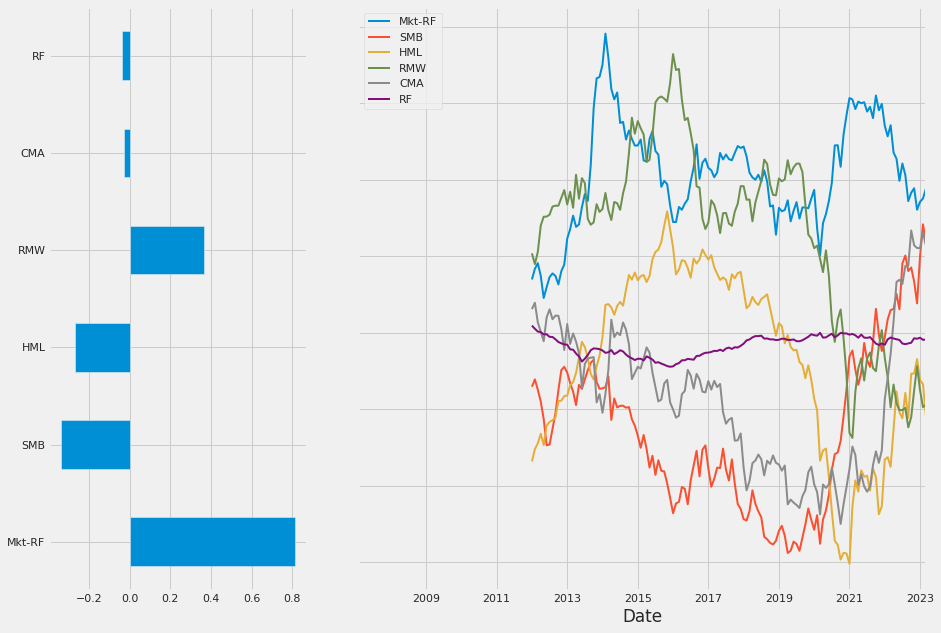

In [44]:
ax1 = plt.subplot2grid((1, 3), (0, 0))
ax2 = plt.subplot2grid((1, 3), (0, 1), colspan=2)
lambdas.mean().plot.barh(ax=ax1)
lambdas.rolling(60).mean().plot(lw=2, figsize=(14,10), sharey=True, ax=ax2);

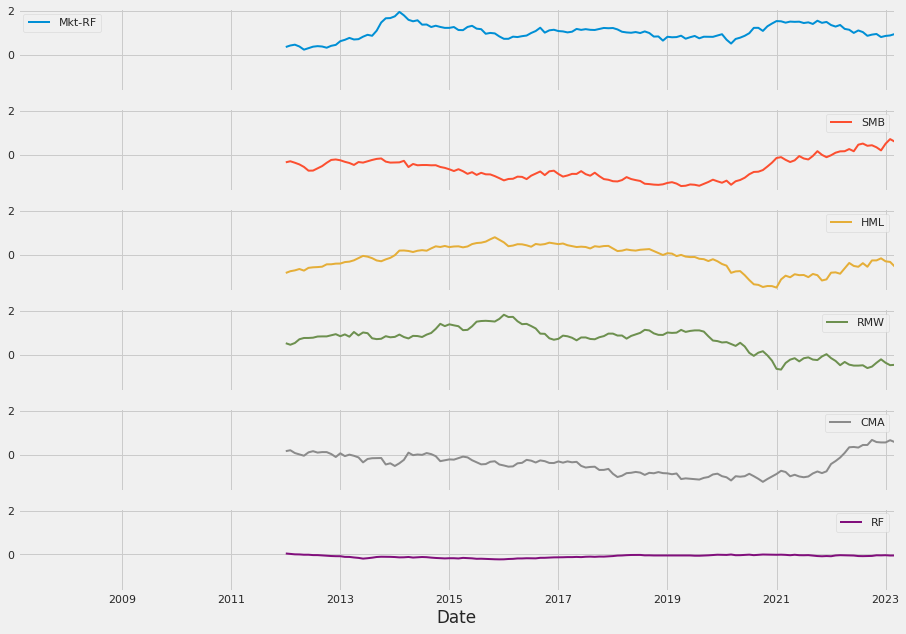

In [45]:
lambdas.rolling(60).mean().plot(lw=2, figsize=(14,10), subplots=True,sharey=True);

## Fama-Macbeth with the LinearModels library

The linear_models library extends statsmodels with various models for panel data and also implements the two-stage Fama—MacBeth procedure:

In [46]:
mod = LinearFactorModel(portfolios=ff_portfolio_data, 
                        factors=ff_factor_data)
res = mod.fit()
print(res)

                      LinearFactorModel Estimation Summary                      
No. Test Portfolios:                 17   R-squared:                      0.7064
No. Factors:                          6   J-statistic:                    6.4927
No. Observations:                   194   P-value                         0.8386
Date:                  Sun, May 14 2023   Distribution:                 chi2(11)
Time:                          12:49:52                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Mkt-RF         0.8141     0.3535     2.3031     0.0213      0.1213      1.5069
SMB           -0.3387     0.3929    

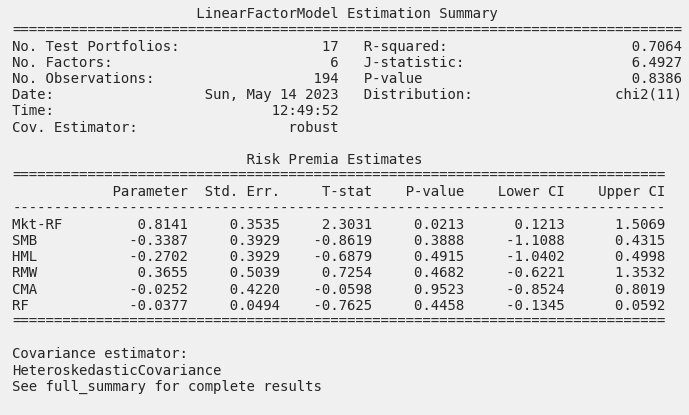

In [47]:
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(res), {'fontsize': 14}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.1)
plt.savefig('factor_model.png', bbox_inches='tight', dpi=300);

This provides us with the same result:

In [48]:
lambdas.mean()

Mkt-RF    0.814121
SMB      -0.338669
HML      -0.270241
RMW       0.365547
CMA      -0.025238
RF       -0.037679
dtype: float64